The aim of this notebook is to code the following approach:

First, solve the colgen without any coverage constraint whatsoever (achieved best by PT NyVA >= with occasional stem-and-blender integer guaranteeing). Then, optimize the coverage vehicle routes according to that job vehicle routing answer.

I'm using this as a starting point into two-stage optimization. I want to make sure I am comfortable manipulating the coverage variables etc. and getting familiar with them.

In [418]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets

using Dates

# [0] Drag job data back into this notebook

In [419]:
n_jobs = 25
n_vehicles_jobs = n_jobs
V_cov = 15
T = 2 * n_jobs
min_duration = 2
max_duration = 6;
speed = 1000 / 6;

In [420]:
time_windows = [[5, 8], [13, 17], [20, 25], [8, 10], [14, 17], [22, 26], [30, 35], 
    [2, 8], [11, 14], [18, 22], [9, 13], [14, 17], [21, 24], [27, 29], [31, 37], 
    [2, 5], [8, 10], [12, 17], [17, 21], [10, 14], [15, 20], [24, 27], [27, 33], 
    [4, 9], [9, 15]];

In [421]:
work_load = [3, 4, 5, 2, 2, 3, 4, 3, 2, 4, 4, 3, 3, 2, 5, 3, 2, 3, 3, 3, 4, 2, 3, 4, 5];

In [422]:
locations = [ [162.98836443179744 274.5255681577834], [109.29332740941533 447.12271410049414],
    [121.1152053108041 446.89270877611096],[89.59124765472993 435.09777866446035],
    [323.92765788592794 498.332645718842],[326.53347225637947 483.83207561135157],
    [328.32265251259605 492.9102875883275],[309.1686841347623 498.8397830821424],
    [36.35807104610789 350.5579177570377],[47.090405717384044 341.3203068534036],
    [55.48085983316444 364.68758998092676],[260.3707024335765 470.9155090761928],
    [260.37715114996485 479.54934664105195],[247.26012681195274 464.00956357114217], 
    [240.48176081945687 456.302922303405],[276.6482779863586 455.5862703353655],
    [239.93121460946887 474.9841599335543],[251.64446751105916 493.673348915355], 
    [246.70672450784087 490.66852195024524],[232.51197192211055 487.17296281307057], 
    [244.46684180873675 245.79037260667468],[225.94275471532777 256.0041140341042],
    [231.9341041485549 256.19089982535576],[241.8876807998831 230.46206318844872],
    [73.90222246114125 139.66111885815096],[65.10392466179182 147.0898582966076]];

In [423]:
distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];

In [424]:
travel_times = ceil.(distances / speed);

In [425]:
routes_nodes_only = [
    [0, 1, 2, 3, 26],
    [0, 8, 9, 10, 26],
    [0, 4, 5, 6, 7, 26],
    [0, 20, 21, 22, 23, 26],
    [0, 24, 25, 26],
    [0, 11, 12, 15, 26],
    [0, 16, 17, 18, 19, 13, 14, 26]
];

In [426]:
full_routes = [
[[[0, 0], [1, 5], 180.7565539293233], [[1, 5], [1, 6], 0], [[1, 6], [1, 7], 0], [[1, 7], [1, 8], 0], [[1, 8], [2, 13], 11.824115170472117], [[2, 13], [2, 14], 0], [[2, 14], [2, 15], 0], [[2, 15], [2, 16], 0], [[2, 16], [2, 17], 0], [[2, 17], [3, 20], 33.658286983158845], [[3, 20], [3, 21], 0], [[3, 21], [3, 22], 0], [[3, 22], [3, 23], 0], [[3, 23], [3, 24], 0], [[3, 24], [3, 25], 0], [[3, 25], [26, 27], 176.55189474538938]],
[[[0, 0], [8, 2], 147.70290920807565], [[8, 2], [8, 3], 0], [[8, 3], [8, 4], 0], [[8, 4], [8, 5], 0], [[8, 5], [9, 11], 14.160383564833829], [[9, 11], [9, 12], 0], [[9, 12], [9, 13], 0], [[9, 13], [10, 18], 24.828001148518656], [[10, 18], [10, 19], 0], [[10, 19], [10, 20], 0], [[10, 20], [10, 21], 0], [[10, 21], [10, 22], 0], [[10, 22], [26, 23], 140.31056169890445]],
[[[0, 0], [4, 8], 275.66476768701585], [[4, 8], [4, 9], 0], [[4, 9], [4, 10], 0], [[4, 10], [5, 14], 14.732847721180612], [[5, 14], [5, 15], 0], [[5, 15], [5, 16], 0], [[5, 16], [6, 22], 9.252842735513466], [[6, 22], [6, 23], 0], [[6, 23], [6, 24], 0], [[6, 24], [6, 25], 0], [[6, 25], [7, 30], 20.050771093158136], [[7, 30], [7, 31], 0], [[7, 31], [7, 32], 0], [[7, 32], [7, 33], 0], [[7, 33], [7, 34], 0], [[7, 34], [26, 36], 267.74157855214145]],
[[[0, 0], [20, 10], 86.39707019931214], [[20, 10], [20, 11], 0], [[20, 11], [20, 12], 0], [[20, 12], [20, 13], 0], [[20, 13], [21, 15], 21.153305098508625], [[21, 15], [21, 16], 0], [[21, 16], [21, 17], 0], [[21, 17], [21, 18], 0], [[21, 18], [21, 19], 0], [[21, 19], [22, 24], 5.99426033492411], [[22, 24], [22, 25], 0], [[22, 25], [22, 26], 0], [[22, 26], [23, 27], 27.587075286128385], [[23, 27], [23, 28], 0], [[23, 28], [23, 29], 0], [[23, 29], [23, 30], 0], [[23, 30], [26, 31], 90.36976592607648]],
[[[0, 0], [24, 4], 161.63155748834768], [[24, 4], [24, 5], 0], [[24, 5], [24, 6], 0], [[24, 6], [24, 7], 0], [[24, 7], [24, 8], 0], [[24, 8], [25, 9], 11.515042935678439], [[25, 9], [25, 10], 0], [[25, 10], [25, 11], 0], [[25, 11], [25, 12], 0], [[25, 12], [25, 13], 0], [[25, 13], [25, 14], 0], [[25, 14], [26, 15], 160.68983694344095]],
[[[0, 0], [11, 9], 219.20841372682088], [[11, 9], [11, 10], 0], [[11, 10], [11, 11], 0], [[11, 11], [11, 12], 0], [[11, 12], [11, 13], 0], [[11, 13], [12, 14], 8.63383997317047], [[12, 14], [12, 15], 0], [[12, 15], [12, 16], 0], [[12, 16], [12, 17], 0], [[12, 17], [15, 31], 28.96512721460351], [[15, 31], [15, 32], 0], [[15, 32], [15, 33], 0], [[15, 33], [15, 34], 0], [[15, 34], [15, 35], 0], [[15, 35], [15, 36], 0], [[15, 36], [26, 38], 213.77921747042998]],
[[[0, 0], [16, 2], 214.71806912830775], [[16, 2], [16, 3], 0], [[16, 3], [16, 4], 0], [[16, 4], [16, 5], 0], [[16, 5], [17, 8], 22.056429410357314], [[17, 8], [17, 9], 0], [[17, 9], [17, 10], 0], [[17, 10], [18, 12], 5.780163583851407], [[18, 12], [18, 13], 0], [[18, 13], [18, 14], 0], [[18, 14], [18, 15], 0], [[18, 15], [19, 17], 14.618821246994681], [[19, 17], [19, 18], 0], [[19, 18], [19, 19], 0], [[19, 19], [19, 20], 0], [[19, 20], [13.0, 21.0], 27.45999157129779], [[13.0, 21.0], [13.0, 22.0], 0], [[13.0, 22.0], [13.0, 23.0], 0], [[13.0, 23.0], [13.0, 24.0], 0], [[13.0, 24.0], [14.0, 27.0], 10.263457758368471], [[14.0, 27.0], [14.0, 28.0], 0], [[14.0, 28.0], [14.0, 29.0], 0], [[14.0, 29.0], [26.0, 31.0], 197.60625740061383]],
];

# [1] Create Coverage Locations

## [1.1] Parameters

The following parameters detail how the grid will shape up. Size is the side length of the full map square, step is the width of the 'steping' of the grid (e.g. step = 40 means every 40 distance in horizontal or vertical direction there will be a new vehicle), which will be a square system. Radius is how well the coverage does, as the crow flies (so not Manhattan/taxicab). Speed is how far we travel per time unit.

In [427]:
size = 500
step = 50
radius = 50
speed = 1000/6;

## [1.2] Consider each potential landing spot for coverage, and see if useful

So now we have a full grid set up, with locations ranging from

`[0, size]` to `[0, size]` with a step, or step, of `step`. Start with `[0, 0]`; we expect step to be divided into size evenly, but if not, like if size is 100 and step is 8, we end at `[96, 96]`.

We consider each of these `floor(size / step) + 1` times `floor(size / step) + 1` locations, and see if, within their coverage, there exists at least a job. How do we run this check? It's kinda hard to 'sweep' the coverage and look for jobs, so instead, we take jobs and match their distance against the radius-squared!

If there is at least a job within the radius, then the coverage location is useful.

If not, then don't add it.

In [428]:
function is_close_enough(coverage_loc, job_loc, r)
    #=
    Given a coverage_loc with 2 elements x y
    and a job_loc with two elements x y
    determines if that specific job_loc is located within r 
    of the coverage_loc as the crow flies
    =#
    
    return (coverage_loc[1]-job_loc[1])^2 + (coverage_loc[2]-job_loc[2])^2 <= r^2
end;

In [429]:
function close_enough_jobs(coverage_loc, r=radius)
    jobs = []
    for i in 1:n_jobs
        if is_close_enough(coverage_loc, locations[i+1], r)
            push!(jobs, i)
        end
    end
    
    return jobs
end;

In [430]:
coverage_locations = []
covered_already = []

for x in 0:step:size
    for y in 0:step:size
        potential_cov = [x y]
        useful = false
        # println("Now considering ", potential_cov)
        
        for index in 2:length(locations) #1st is depot
            if is_close_enough(potential_cov, locations[index], radius)
                for job in close_enough_jobs(potential_cov)
                    if ~(job in covered_already)
                        push!(covered_already, job)
                        useful = true
                    end
                end
                break
            end
        end
        
        if useful
            push!(coverage_locations, potential_cov)
        end
    end
end;

In [431]:
coverage_locations;

In [432]:
m_cov = length(coverage_locations);

## [1.3] Generate map of coverage and job locations

This is good for visual inspection and seeing if we want to change anything.

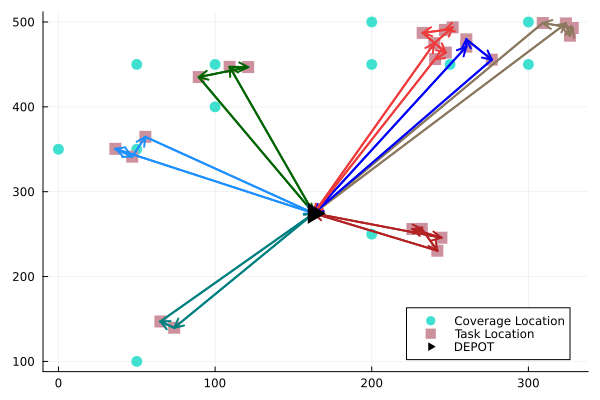

In [433]:
x_values = []
y_values = []
for i in 2:length(locations)
    push!(x_values, locations[i][1])
    push!(y_values, locations[i][2])
end

cov_x = []
cov_y = []
for i in 1:length(coverage_locations)
    push!(cov_x, coverage_locations[i][1])
    push!(cov_y, coverage_locations[i][2])
end

xcs = []
ycs = []
xvecs = []
yvecs = []
# now, the arrows to indicate routes
for route_node_series in routes_nodes_only
    xc, yc, xv, yv = [], [], [], []
    for index in 1:length(route_node_series)-1
        lindex1 = 1 + route_node_series[index] % (n_jobs+1)
        lindex2 = 1 + route_node_series[index+1] % (n_jobs+1)
        x1, y1 = locations[lindex1]
        x2, y2 = locations[lindex2]
        push!(xc, x1); push!(yc, y1); push!(xv, x2-x1); push!(yv, y2-y1)
    end
    push!(xcs, xc); push!(ycs, yc); push!(xvecs, xv); push!(yvecs, yv)
end

scatter(cov_x, cov_y; label = "Coverage Location", markershape = :circle,
markercolor = :turquoise, markersize = 6, markerstrokecolor = :turquoise, markerstrokewidth=3,)
scatter!(x_values, y_values; label = "Task Location", markershape = :square, 
markercolor = :pink3, markersize = 6, markerstrokecolor = :pink3, markerstrokewidth = 3)
colors = [:darkgreen, :dodgerblue, :navajowhite4, :firebrick, :teal, :blue, :brown2]
for i in 1:length(xcs)
    quiver!(xcs[i], ycs[i], quiver = (xvecs[i], yvecs[i]), linewidth=2, c=colors[i])
end
display(scatter!([locations[1][1]], [locations[1][2]]; label = "DEPOT", markershape = :rtriangle,
markercolor = :black, markersize = 15, markerstrokecolor = :black))

# [2] Prepare Calculations for DF Model

## [2.1] Coverage Parameters
Coverage distances, coverage nodes, coverage arcs.

### [2.1.1] Coverage Distances

First we need to gather distances to and from the depot and other coverage locations. To do so most quickly, we temporarily modify coverage locations to also include the depot.

In [434]:
insert!(coverage_locations, 1, locations[1]);

In [435]:
coverage_distances = [LinearAlgebra.norm(coverage_locations[i, :] .- coverage_locations[j, :]) for i=1:m_cov+1, j = 1:m_cov+1];

In [436]:
coverage_locations = coverage_locations[2:end];

### [2.1.2] Coverage Nodes

In [437]:
cov_nodes = []
for j in 1:m_cov
    for t in 1:T-1
        push!(cov_nodes, [j, t])
    end
end;

### [2.1.3] Coverage Arcs

In [438]:
cov_arcs = []
push!(cov_arcs, [ [0, 0], [m_cov + 1, 0], 0]);

In [439]:
# Origin depot to some spot
for j in 1:m_cov
    for t in 0:T-1
        dist = coverage_distances[0+1, j+1]
        time_travel = ceil(dist / speed)
        last_time = t + time_travel
        if last_time <= T-time_travel
            start = [0, t]
            end_ = [j, last_time]
            push!(cov_arcs, [ start, end_, dist])
        end
    end
end;

In [440]:
# Some place to end-depot
for j in 1:m_cov
    for t in 1:T-1
        dist = coverage_distances[0+1, j+1]
        time_travel = ceil(dist / speed)
        return_time = t + time_travel
        if return_time <= T
            start = [j, t]
            last = [m_cov+1, return_time]
            push!(cov_arcs, [start, last, dist])
        end
    end
end;

In [441]:
# Some place to some place
for j in 1:m_cov
    for j_prime in 1:m_cov
        for t in 1:T-1
            if j == j_prime && t <= T-2
                push!(cov_arcs, [[j, t], [j_prime, t+1], 0])
            else
                #not similar nodes
                dist = coverage_distances[j+1, j_prime+1]
                time_travel = ceil(dist/speed)
                new_time = t + time_travel
                
                if new_time <= T-1
                    start = [j, t]
                    next = [j_prime, t+new_time]
                    push!(cov_arcs, [start, next, dist])
                end
            end
        end
    end
end;

In [442]:
A = length(cov_arcs);

## [2.2] $L_{ji}$

Whether coverage spot $j$ is close enough to job node $i$ to cover. 1 if yes, 0 if no.

In [443]:
function calculate_L(cov_locs, job_locs, r=radius)
    #=
    Given a list of tuple coverage locations and job locations,
    returns a matrix of L values. Specifically, 
    L[j][i], indicating if spot j is close enough to node i
    for coverage to happen.
    =#
    L = []
    for j in 1:length(cov_locs)
        L_j = []
        cov_loc = cov_locs[j]
        for i in 1:length(job_locs)
            push!(L_j, (is_close_enough(cov_loc, job_locs[i], r)) ? 1 : 0)
        end
        push!(L, L_j)
    end
    
    return L
end;

In [444]:
L = calculate_L(coverage_locations, locations[2:end], radius);

## [2.3] $W_{it}$

Whether a job is being performed at job node $i$ at time $t$.

In [445]:
function calculate_W(full_routes)
    #=
    Given the full solution routes to the job problem,
    tells us W[i][t], which is whether job i is being
    done at time t.
    
    Our strategy is to gather the FIRST node of each arc,
    because it's the same as the second node of the arc prior.
    
    Disregard the 1st node (its start is the origin-depot), 
    that information is contained in the 2nd node.
    =#
    W = [ [0 for t in 1:T] for i in 1:n_jobs]
    
    for route in full_routes
        for arc in route[2:end]
            loc = Int(arc[1][1])
            time = Int(arc[1][2])
            W[loc][time] = 1
        end
    end
    
    return W
end;   

In [446]:
W = calculate_W(full_routes);

## [2.4] $c_a$

What is the cost of arc $a$? Well...it's arc[3]. But I don't like to have to reference it like that.

In [447]:
function calculate_c(arc_system)
    c = []
    for arc in arc_system
        push!(c, arc[3])
    end
    return c
end;

In [448]:
c = calculate_c(cov_arcs);

## [2.5] valid($j$, $t$)

All arcs which visit spot $j$ at time $t$.

In [449]:
function valid(j, t)
    #=
    Given a spot j and a time t, returns all arc INDEX NUMBERS
    which are at spot j at time t.
    
    Why do we return index numbers? Because when we actually
    code this thing, we will need "for a in valid(j, t)".
    We return the INDEX of the arc.
    =#
    valids = []
    for arcindex in 1:A
        arc = cov_arcs[arcindex]
        if (arc[1][1] == j && arc[1][2] == t) || (arc[2][1] == j && arc[2][2] == t)
            push!(valids, arcindex)
        end
    end
    return valids
end;

## [2.6] $P_{ajt}$

Alternate for valid function, tells us if arc $a$ visits spot $j$ at time $t$.

In [450]:
function calculate_P()
    # P_ajt, P[a][j][t] tells us if arc a visits spot j at time t.
    P = [ [ [0 for t in 1:T] for j in 1:m_cov] for a in 1:A]
    
    for a in 1:length(cov_arcs)
        for j in 1:m_cov
            for t in 1:T
                arc = cov_arcs[a]
                if (arc[1][1] == j && arc[1][2] == t) || (arc[2][1] == j && arc[2][2] == t)
                    P[a][j][t] = 1
                end
            end
        end
    end
    
    return P
end;

In [451]:
# P = calculate_P();

# [3] DF Model

In [452]:
model = Model(Gurobi.Optimizer);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


In [453]:
V_cov = m_cov;

## [3.1] Variables

In [454]:
@variable(model, x[1:V_cov, 1:A], Bin);

In [455]:
@variable(model, gamma[1:m_cov, 1:T-1], Bin);

## [3.2] Objective

In [456]:
@objective(model, Min, 
    sum(sum(c[a] * x[v, a] for a in 1:A) for v in 1:V_cov));

## [3.3] Flow Constraints

In [457]:
function depot_origin_arcs()
    # returns INDICES of arcs that start at (0, something).
    origin = []
    for aindex in 1:A
        if cov_arcs[aindex][1][1] == 0
            push!(origin, aindex)
        end
    end
    
    return origin;
end;

In [458]:
function depot_end_arcs()
    # returns INDICES of arcs that end at (m_cov+1, something).
    terms = []
    for aindex in 1:A
        if cov_arcs[aindex][2][1] == m_cov+1
            push!(terms, aindex)
        end
    end
    
    return terms;
end;

In [459]:
@constraint(model, origin_depot[v in 1:V_cov], 
    sum(x[v, a] for a in depot_origin_arcs()) == 1);
@constraint(model, end_depot[v in 1:V_cov], 
    sum(x[v, a] for a in depot_end_arcs()) == 1);

In [460]:
function incoming_into(spot)
    # returns INDICES of arcs that have second location-time spot.
    incoming = []
    for aindex in 1:A
        if cov_arcs[aindex][2] == spot
            push!(incoming, aindex)
        end
    end
    
    return incoming;
end;

In [461]:
function outgoing_away(spot)
    # return INDICES of arcs that start at this spot.
    outgoing = []
    for aindex in 1:A
        if cov_arcs[aindex][1] == spot
            push!(outgoing, aindex)
        end
    end
    
    return outgoing;
end;

In [462]:
#total nightmare, takes 269 seconds
# time1 = datetime2unix(now())
@constraint(model, flow_equal[v in 1:V_cov, m in cov_nodes], 
    sum(x[v, a] for a in incoming_into(cov_nodes[m])) == 
    sum(x[v, a] for a in outgoing_away(cov_nodes[m])));
# time2 = datetime2unix(now());

## [3.4] Coverage Constraints

In [463]:
@constraint(model, cov_exists[j in 1:m_cov, t in 1:T-1], 
    sum(sum(x[v, a] for a in valid(j, t)) for v in V_cov) >= gamma[j, t]);

In [464]:
@constraint(model, must_cover[i in 1:n_jobs, t in 1:T-1], 
    sum(L[j][i] * gamma[j, t] for j in 1:m_cov) >= W[i][t]);

In [465]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8893 rows, 96372 columns and 28254 nonzeros
Model fingerprint: 0x5325dbd5
Variable types: 0 continuous, 96372 integer (96372 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4300.6348391
Presolve removed 8893 rows and 96372 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.02 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 0 4300.63 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

User-callback calls 211, time in user-callback 0.00 sec
